In [1]:
%run WLS_data.ipynb

      T_ID   GDAY_DS  HEADER_NO   P_ID  START_CK  BAT_ORDER_NO   PA   AB  RBI  \
0       HH  20160401          0  60404         0             3    1    1    0   
1       HH  20160401          0  62700         1             9    2    2    0   
2       HH  20160401          0  64086         1             7    6    4    0   
3       HH  20160401          0  66740         1             5    6    6    0   
4       HH  20160401          0  71347         1             2    6    6    1   
...    ...       ...        ...    ...       ...           ...  ...  ...  ...   
18679   WO  20161009          0  74215        91           374  402  341   80   
18680   WO  20161009          0  78168       139           177  646  560   63   
18681   WO  20161009          0  79130        15           251   80   66    7   
18682   WO  20161009          0  79300        13           429  106   91    9   
18683   WO  20161009          0  79365       122           965  454  411   70   

       RUN  ...  BB  IB  HP

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import kerastuner as kt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA

from tensorflow import keras
from tensorflow.keras import backend as K

feature, target = WLS_data("HT")

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning: 
A va

In [3]:
feature.columns

Index(['AB_BAT', 'MONEY_BAT', 'PA_BAT', 'AGE_VA_BAT', 'K/PA_BAT', 'ISO_BAT',
       'BABIP_BAT_BAT', 'BPF_BAT', 'PA_PIT', 'BF_PIT', 'MONEY_PIT',
       'AGE_VA_PIT', 'K/9_PIT', 'BB/9_PIT', 'LOB%_PIT', 'FIP_PIT', 'DER_PIT',
       'PPF_PIT', 'PE', 'BS_PCA', 'ER_PCA'],
      dtype='object')

In [3]:
trainFeature = feature.loc[0:feature.shape[0]-29]
trainTarget = target.loc[0:feature.shape[0]-29]

testFeature = feature.loc[feature.shape[0]-29:].reset_index(drop = True)
testTarget = target[feature.shape[0]-29:].reset_index(drop = True)
trainFeature.shape

(615, 21)

In [4]:

standardizer = PowerTransformer()
res = standardizer.fit(trainFeature)
res = standardizer.transform(trainFeature)

trainFeature = pd.DataFrame(res, columns = trainFeature.columns, index = list(trainFeature.index.values))

res = standardizer.transform(testFeature)
testFeature = pd.DataFrame(res, columns = testFeature.columns, index = list(testFeature.index.values))

scaler = MinMaxScaler()
res = scaler.fit(trainFeature)
res = scaler.transform(trainFeature)
trainFeature = pd.DataFrame(res, columns = trainFeature.columns, index = list(trainFeature.index.values))

res = scaler.transform(testFeature)
testFeature = pd.DataFrame(res, columns = testFeature.columns, index = list(testFeature.index.values))

In [5]:
def win_ratio_loss(y_true, y_pred) :
    real_win_ratio = K.mean(y_true)
    pred_win_ratio = K.mean(y_pred)
    return K.square(real_win_ratio - pred_win_ratio)

In [6]:
class MCDropout(keras.layers.Dropout) :
    def call(self, inputs) :
        return super().call(inputs, training = True)


model = keras.Sequential()
model.add(keras.layers.Input(shape = trainFeature.shape[1]))
model.add(keras.layers.Dense(100, activation = "selu", kernel_initializer = "lecun_normal"))
model.add(MCDropout(rate = 0.2))
model.add(keras.layers.Dense(100, activation = "selu", kernel_initializer = "lecun_normal"))
model.add(MCDropout(rate = 0.2))
model.add(keras.layers.Dense(100, activation = "selu", kernel_initializer = "lecun_normal"))
model.add(MCDropout(rate = 0.2))
model.add(keras.layers.Dense(100, activation = "selu", kernel_initializer = "lecun_normal"))
model.add(MCDropout(rate = 0.2))
model.add(keras.layers.Dense(100, activation = "selu", kernel_initializer = "lecun_normal"))
model.add(MCDropout(rate = 0.2))
model.add(keras.layers.Dense(1, activation = "sigmoid"))

optimizer = keras.optimizers.Nadam(learning_rate = 0.0001)

model.compile(optimizer = optimizer, loss = win_ratio_loss)
history = model.fit(trainFeature, trainTarget, epochs = 500, validation_split = 0.3, shuffle = True, use_multiprocessing = True, batch_size = 29)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 430 samples, validate on 185 samples
Epoch 1/500
430/430 [==============================] - ETA: 6s - loss: 0.005 - 1s 2ms/sample - loss: 0.0153 - val_loss: 0.0106
Epoch 2/500
430/430 [==============================] - ETA: 0s - loss: 0.007 - 0s 165us/sample - loss: 0.0138 - val_loss: 0.0267
Epoch 3/500
430/430 [==============================] - ETA: 0s - loss: 0.002 - 0s 165us/sample - loss: 0.0276 - val_loss: 0.0151
Epoch 4/500
430/430 [==============================] - ETA: 0s - loss: 0.006 - 0s 165us/sample - loss: 0.0104 - val_loss: 0.0060
Epoch 5/500
430/430 [==============================] - ETA: 0s - loss: 0.001 - 0s 158us/sample - loss: 0.0074 - val_loss: 0.0089
Epoch 6/500
430/430 [==============================] - ETA: 0s - loss: 0.002 - 0s 149us/sample - loss: 0.0129 - val_loss: 0.0110
Epoch 7/500
430/430 [==============================] - ETA: 0s - loss: 0.020 - 0s 168us/

In [9]:
class MCDropout(keras.layers.Dropout) :
    def call(self, inputs) :
        return super().call(inputs, training = True)
    
def make_model(hp) :
    model = keras.Sequential()

    model.add(keras.layers.Input(shape = (trainFeature.shape[1])))
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(keras.layers.Dense(units=hp.Int('units_' + str(i), 32, 512, 32),
                               activation="selu", kernel_initializer = "lecun_normal"))
        model.add(MCDropout(rate = hp.Choice("rate", values = [0.1, 0.2, 0.3, 0.4, 0.5])))

    model.add(keras.layers.Dense(1, activation = None))

    optimizer = keras.optimizers.Nadam(hp.Choice("learning_rate", values = [0.005, 0.001, 0.0005, 0.0001]))

    model.compile(optimizer = optimizer, loss = win_ratio_loss)
    return model

tuner = kt.BayesianOptimization(make_model, objective = "val_loss", max_trials = 15, executions_per_trial = 9, project_name = "HT_WLS")
early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0.0001, patience = 30, mode = "min", restore_best_weights = True)

tuner.search(trainFeature, trainTarget, epochs = 500, validation_split = 0.3, shuffle = True, use_multiprocessing = True, callbacks = [early_stop], batch_size = 29)


INFO:tensorflow:Reloading Oracle from existing project .\HH_batter\oracle.json
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Reloading Tuner from .\HH_batter\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [10]:
best = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               6656      
_________________________________________________________________
mc_dropout (MCDropout)       (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
mc_dropout_1 (MCDropout)     (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                16416     
_________________________________________________________________
mc_dropout_2 (MCDropout)     (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1

In [ ]:
result = np.zeros(shape = (29, ))
for i in range(100) :
    best = tuner.get_best_hyperparameters()[0]
    model = tuner.hypermodel.build(best)
    model.fit(trainFeature, trainTarget, epochs = 500, validation_split = 0.3, shuffle = True, use_multiprocessing = True,
                    callbacks = [early_stop], batch_size = 29)
    result += model.predict(testFeature).reshape(29, )
result /= 100

Train on 406 samples, validate on 175 samples
Epoch 1/500
406/406 [==============================] - ETA: 36s - loss: 8.56 - ETA: 11s - loss: 7.51 - ETA: 6s - loss: 7.6457 - ETA: 4s - loss: 7.242 - ETA: 2s - loss: 7.197 - ETA: 1s - loss: 7.188 - ETA: 1s - loss: 7.114 - ETA: 0s - loss: 6.832 - ETA: 0s - loss: 6.653 - ETA: 0s - loss: 6.570 - 6s 14ms/sample - loss: 6.4632 - val_loss: 5.9169
Epoch 2/500
406/406 [==============================] - ETA: 0s - loss: 6.816 - ETA: 0s - loss: 5.639 - ETA: 0s - loss: 5.347 - ETA: 0s - loss: 5.295 - ETA: 0s - loss: 5.230 - ETA: 0s - loss: 5.109 - ETA: 0s - loss: 5.218 - ETA: 0s - loss: 5.382 - ETA: 0s - loss: 5.295 - ETA: 0s - loss: 5.309 - 1s 2ms/sample - loss: 5.3657 - val_loss: 4.0295
Epoch 3/500
406/406 [==============================] - ETA: 0s - loss: 3.484 - ETA: 0s - loss: 3.177 - ETA: 0s - loss: 3.396 - ETA: 0s - loss: 3.311 - ETA: 0s - loss: 3.663 - ETA: 0s - loss: 3.775 - ETA: 0s - loss: 4.018 - ETA: 0s - loss: 3.992 - ETA: 0s - loss: 3.9

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



406/406 [==============================] - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - 1s 2ms/sample - loss: 0.0068 - val_loss: 0.0065
Epoch 110/500
406/406 [==============================] - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - 1s 2ms/sample - loss: 0.0068 - val_loss: 0.0068
Epoch 111/500
406/406 [==============================] - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - 1s 2ms/sample - loss: 0.0062 - val_loss: 0.0064
Epoch 112/500
406/406 [====

In [11]:
best = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best)
history = model.fit(trainFeature, trainTarget, epochs = 500, validation_split = 0.3, shuffle = True, use_multiprocessing = True, callbacks = [early_stop], batch_size = 29)
result = model.predict(testFeature)

Train on 406 samples, validate on 175 samples
Epoch 1/500
406/406 [==============================] - ETA: 32s - loss: 5.70 - ETA: 7s - loss: 8.1451 - ETA: 3s - loss: 8.170 - ETA: 1s - loss: 7.312 - ETA: 1s - loss: 7.346 - ETA: 0s - loss: 7.138 - ETA: 0s - loss: 7.360 - 5s 11ms/sample - loss: 7.2472 - val_loss: 5.9063
Epoch 2/500
406/406 [==============================] - ETA: 0s - loss: 10.04 - ETA: 0s - loss: 6.5905 - ETA: 0s - loss: 6.359 - ETA: 0s - loss: 6.157 - ETA: 0s - loss: 6.136 - ETA: 0s - loss: 6.141 - ETA: 0s - loss: 5.975 - 1s 1ms/sample - loss: 5.8786 - val_loss: 5.0160
Epoch 3/500
406/406 [==============================] - ETA: 0s - loss: 4.086 - ETA: 0s - loss: 4.066 - ETA: 0s - loss: 4.050 - ETA: 0s - loss: 3.989 - ETA: 0s - loss: 3.987 - ETA: 0s - loss: 4.257 - ETA: 0s - loss: 4.268 - ETA: 0s - loss: 4.252 - 1s 1ms/sample - loss: 4.2645 - val_loss: 4.4677
Epoch 4/500
406/406 [==============================] - ETA: 0s - loss: 4.872 - ETA: 0s - loss: 5.146 - ETA: 0s - l

In [9]:
result = model.predict(testFeature)
result.mean()

0.51930803

In [10]:
sum(testTarget) / len(testTarget)

0.5172413793103449

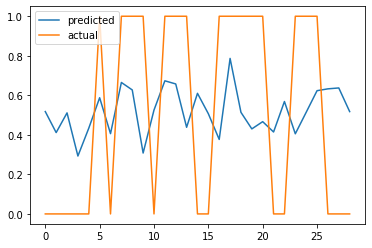

In [11]:
plt.plot(result, label = "predicted")
plt.plot(testTarget, label = "actual")
plt.legend()

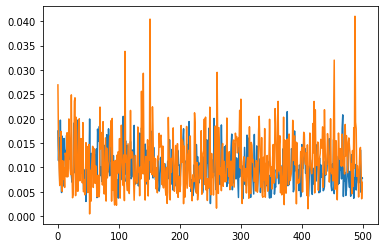

In [12]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])